# Playground

## Load

In [1]:
from __future__ import annotations
from pathlib import Path

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns

import pymc3 as pm
import theano.tensor as tt
import arviz as az

In [2]:
from m5.data.ready import load_ds, path_ds
# from m5.data.prep import *
# from m5.data.raw import calendar, sell_prices, sales_train_eval, sales_train_valid, sample_submission

In [3]:
ds_all = load_ds()
# ds_all = load_ds(recalc=True)
ds = ds_all.where(ds_all['historic'], drop=True)
vars_int = ['sales', 'wday', 'month', 'year', 'event', 'snap']
for v in vars_int:
    ds[v] = ds[v].astype(int)
ds

<xarray.Dataset>
Dimensions:     (date: 1941, event_name: 30, item_id: 3049, store_id: 10)
Coordinates:
  * item_id     (item_id) object 'FOODS_1_001' ... 'HOUSEHOLD_2_516'
    cat_id      (item_id) object 'FOODS' 'FOODS' ... 'HOUSEHOLD' 'HOUSEHOLD'
    dept_id     (item_id) object 'FOODS_1' 'FOODS_1' ... 'HOUSEHOLD_2'
  * store_id    (store_id) object 'CA_1' 'CA_2' 'CA_3' ... 'WI_1' 'WI_2' 'WI_3'
    state_id    (store_id) object 'CA' 'CA' 'CA' 'CA' ... 'TX' 'WI' 'WI' 'WI'
  * date        (date) datetime64[ns] 2011-01-29 2011-01-30 ... 2016-05-22
  * event_name  (event_name) object 'SuperBowl' 'ValentinesDay' ... 'Easter'
    event_type  (event_name) object 'Sporting' 'Cultural' ... 'Cultural'
    historic    (date) bool True True True True True ... True True True True
    future      (date) bool False False False False ... False False False False
Data variables:
    sales       (item_id, store_id, date) int64 3 0 0 1 4 2 0 ... 0 0 0 0 0 0 0
    price       (item_id, store_id, date) float64 2.0 2.0 2.0 ... 5.94 5.94 5.94
    wday        (date) int64 1 2 3 4 5 6 7 1 2 3 4 5 ... 5 6 7 1 2 3 4 5 6 7 1 2
    month       (date) int64 1 1 1 2 2 2 2 2 2 2 2 2 ... 5 5 5 5 5 5 5 5 5 5 5 5
    year        (date) int64 2011 2011 2011 2011 2011 ... 2016 2016 2016 2016
    event       (date, event_name) int64 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    snap        (date, store_id) int64 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0

## EDA

### Aggregate sales

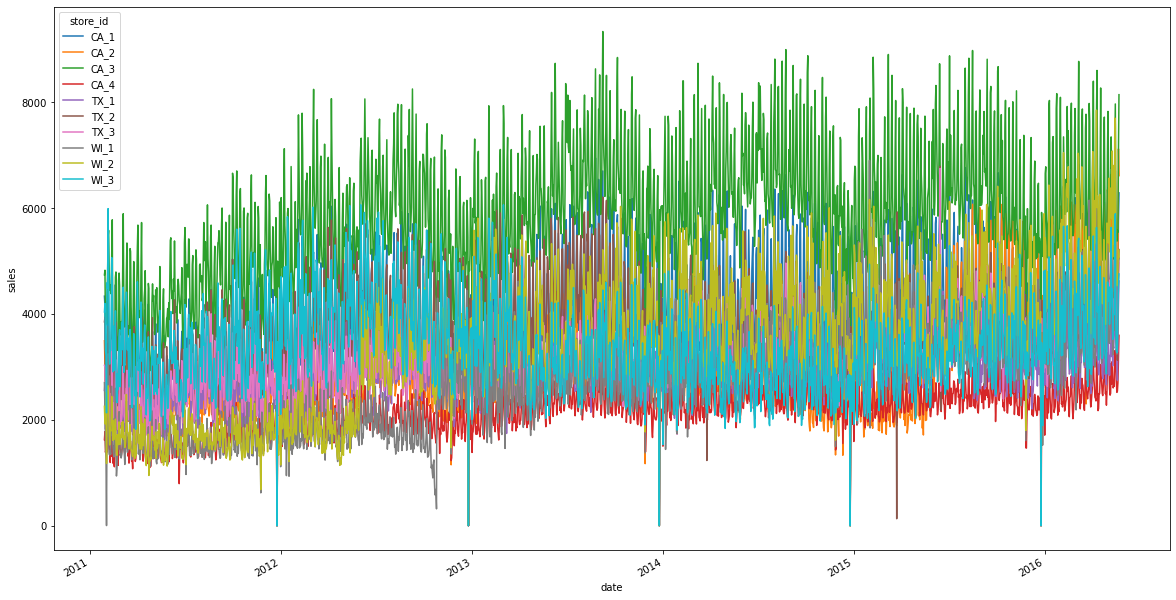

In [4]:
ds['sales'].sum(dim='item_id').plot.line(x='date', figsize=(20, 10));

### Prices (indexed)

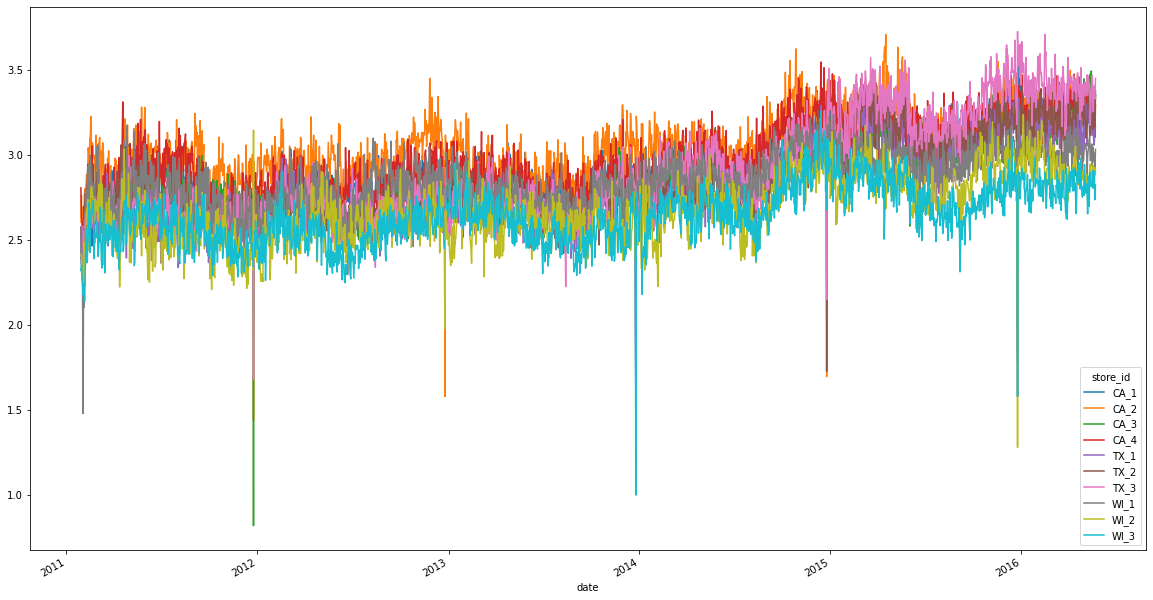

In [5]:
avg_price = (ds['sales'] * ds['price']).sum(dim='item_id') / ds['sales'].sum(dim='item_id')
avg_price.plot.line(x='date', figsize=(20, 10));

### Sparsity of sales



In [6]:
(ds['sales'] == 0).mean(dim=['date', "item_id"])

<xarray.DataArray 'sales' (store_id: 10)>
array([0.63759049, 0.68810291, 0.59399768, 0.71999519, 0.70714074,
       0.66314172, 0.69715073, 0.68754056, 0.70480047, 0.7003161 ])
Coordinates:
  * store_id  (store_id) object 'CA_1' 'CA_2' 'CA_3' ... 'WI_1' 'WI_2' 'WI_3'
    state_id  (store_id) object 'CA' 'CA' 'CA' 'CA' 'TX' ... 'TX' 'WI' 'WI' 'WI'

## Model - Store Volume

### Prepare data

In [7]:
x = (
    ds
    #.where(ds["store_id"] == "CA_1", drop=True)
    #.where(ds["dept_id"] == "FOODS_1", drop=True)
    .isel({"item_id": list(range(20))})
    .transpose("date", "item_id", "store_id", "event_name")
)

In [14]:
d = x.copy()
d["log_price"] = np.log(d["price"]).fillna(0)
d.coords["day_of_week"] = np.arange(7, dtype=int)
d.coords["month_of_year"] = np.arange(12, dtype=int)

ref_date_ns = pd.Timestamp("2010-01-01").to_datetime64().astype(float)
d["date_f"] = (d["date"].astype(float) - ref_date_ns) / 1e15

_sls = d['sales'].sum(dim='item_id')
_sls = _sls.where(_sls > 0)
d["store_sales"] = _sls.fillna(_sls.mean(dim='date'))

### Define model

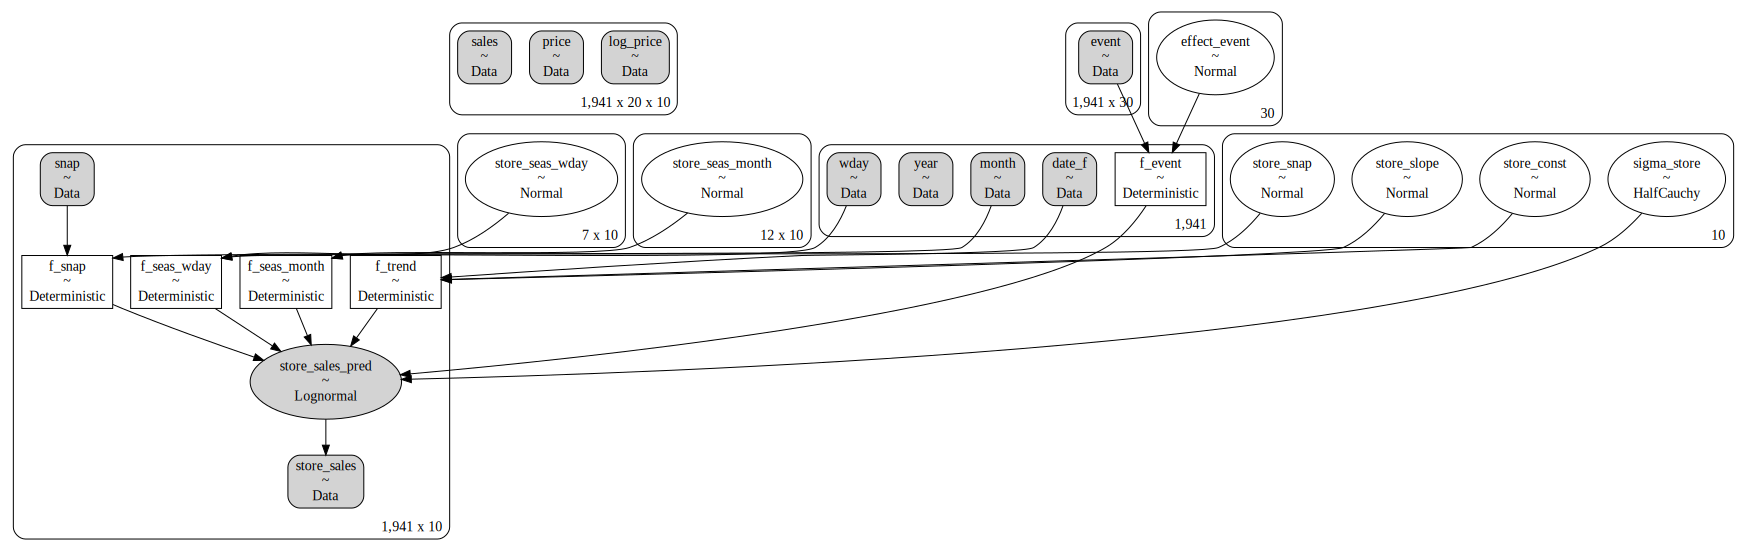

In [23]:
with pm.Model(coords=d.coords) as m:
    for k, v in d.data_vars.items():
        pm.Data(k, v, dims=v.dims)

    pm.Normal("store_const", mu=0, sd=2, dims=["store_id"])
    pm.Normal("store_slope", mu=0, sd=2, dims=["store_id"])
    pm.Deterministic(
        "f_trend",
        m["store_const"][np.newaxis, :]
        + m["date_f"][:, np.newaxis] * m["store_slope"][np.newaxis, :],
        dims=["date", "store_id"],
    )

    pm.Normal("store_seas_wday", mu=0, sd=1, dims=["day_of_week", "store_id"])
    pm.Deterministic(
        "f_seas_wday", m["store_seas_wday"][m["wday"] - 1, :], dims=["date", "store_id"]
    )

    pm.Normal("store_seas_month", mu=0, sd=1, dims=["month_of_year", "store_id"])
    pm.Deterministic(
        "f_seas_month",
        m["store_seas_month"][m["month"] - 1, :],
        dims=["date", "store_id"],
    )

    pm.Normal("store_snap", mu=0, sd=1, dims=["store_id"])
    pm.Deterministic(
        "f_snap", m["store_snap"][np.newaxis, :] * m["snap"], dims=["date", "store_id"]
    )

    pm.Normal("effect_event", mu=0, sd=1, dims=["event_name"])
    pm.Deterministic("f_event", m["event"] @ m["effect_event"], dims=["date"])

    # Sigma
    pm.HalfCauchy("sigma_store", beta=2, dims=["store_id"])
    # pm.Exponential("sigma_store", lam=2, dims=['store_id'])

    pm.Lognormal(
        "store_sales_pred",
        mu=(
            m["f_trend"]
            + m["f_seas_wday"]
            + m["f_seas_month"]
            + m["f_snap"]
            + m["f_event"][:, np.newaxis]
        ),
        sigma=m["sigma_store"],
        observed=m["store_sales"],
        dims=["date", "store_id"],
    )

gv = pm.model_to_graphviz(m)
display(gv)

In [24]:
with m:
    trace = pm.sample(
        draws=500,
        tune=500,
        chains=4,
        target_accept=0.8,
        return_inferencedata=True,
        # init="adapt_diag",
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_store, effect_event, store_snap, store_seas_month, store_seas_wday, store_slope, store_const]


Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 7247 seconds.


0, dim: date, 1941 =? 1941
1, dim: store_id, 10 =? 10


The acceptance probability does not match the target. It is 0.8980835597939031, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [25]:
tm = trace.posterior.mean(dim=['chain', 'draw'])
tm

<xarray.Dataset>
Dimensions:           (date: 1941, day_of_week: 7, event_name: 30, month_of_year: 12, store_id: 10)
Coordinates:
  * store_id          (store_id) object 'CA_1' 'CA_2' 'CA_3' ... 'WI_2' 'WI_3'
  * day_of_week       (day_of_week) int64 0 1 2 3 4 5 6
  * month_of_year     (month_of_year) int64 0 1 2 3 4 5 6 7 8 9 10 11
  * event_name        (event_name) object 'SuperBowl' ... 'Easter'
  * date              (date) datetime64[ns] 2011-01-29 2011-01-30 ... 2016-05-22
Data variables:
    store_const       (store_id) float64 3.572 3.308 3.2 ... 3.215 2.65 2.535
    store_slope       (store_id) float64 0.002824 0.002217 ... 0.005082 0.001923
    store_seas_wday   (day_of_week, store_id) float64 -0.08253 0.4751 ... 0.2205
    store_seas_month  (month_of_year, store_id) float64 -0.0092 ... 0.1194
    store_snap        (store_id) float64 -0.02002 0.03409 ... 0.2088 0.1412
    effect_event      (event_name) float64 -0.2809 0.1449 ... 0.02844 0.02352
    f_trend           (date, store_id) float64 3.668 3.384 3.278 ... 3.674 2.922
    f_seas_wday       (date, store_id) float64 -0.08253 0.4751 ... 0.2324 0.1939
    f_seas_month      (date, store_id) float64 -0.0092 -0.2083 ... 0.3044
    f_snap            (date, store_id) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    f_event           (date) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    sigma_store       (store_id) float64 0.4037 0.4128 0.4018 ... 0.5125 0.5264

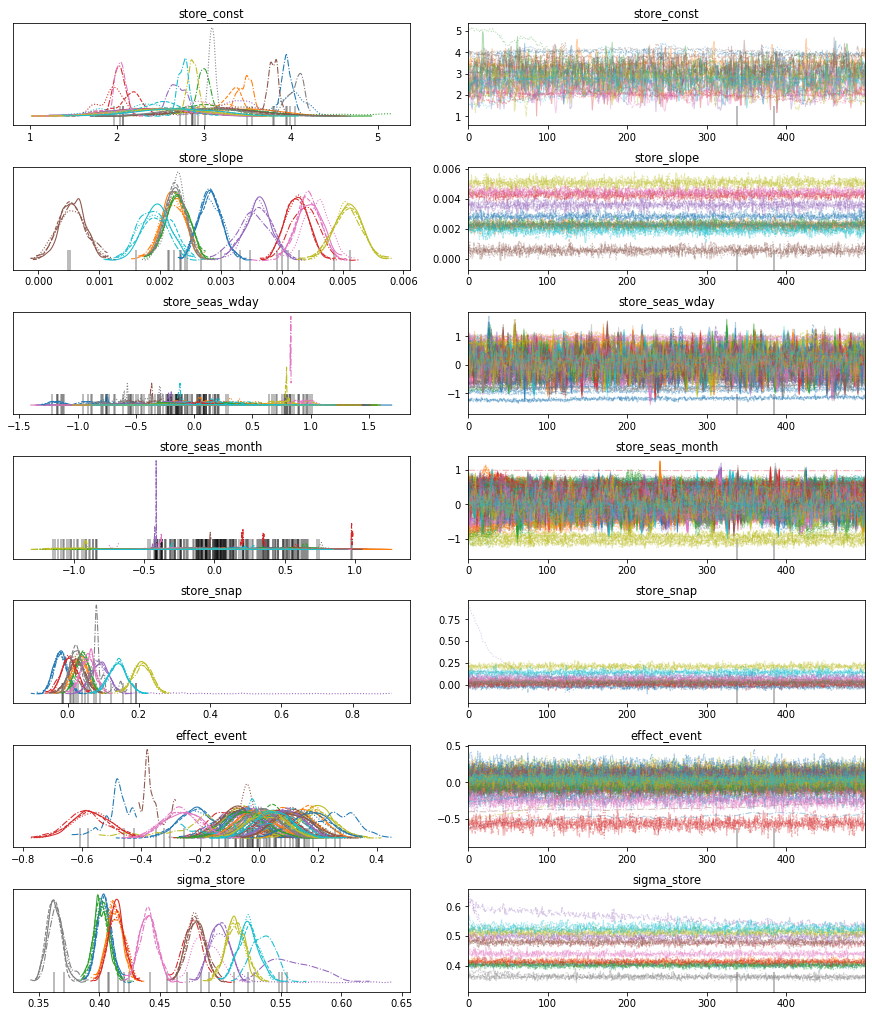

In [27]:
az.plot_trace(
    trace,
    var_names=[
        "store_const",
        "store_slope",
        "store_seas_wday",
        "store_seas_month",
        "store_snap",
        "effect_event",
        "sigma_store",
    ],
);

In [28]:
with m:
    ppc_raw = pm.sample_posterior_predictive(trace)
    ifd2 = az.from_pymc3(posterior_predictive=ppc_raw)
ppc = ifd2.posterior_predictive
# dims = ['sample', 'item_id', 'store_id', 'date']
# coords = {k: x.coords[k] for k in dims if k in x.coords}
# ppc = xr.DataArray(ppc_raw['y'], dims=dims, coords=coords).to_dataset(name='y')

In [31]:
_raw = ppc['store_sales_pred']
q = xr.Dataset({
    "actual": d["store_sales"],
    "raw": _raw,
    "mean": _raw.mean(dim=['chain', 'draw']),
    "median": _raw.median(dim=['chain', 'draw']),
})

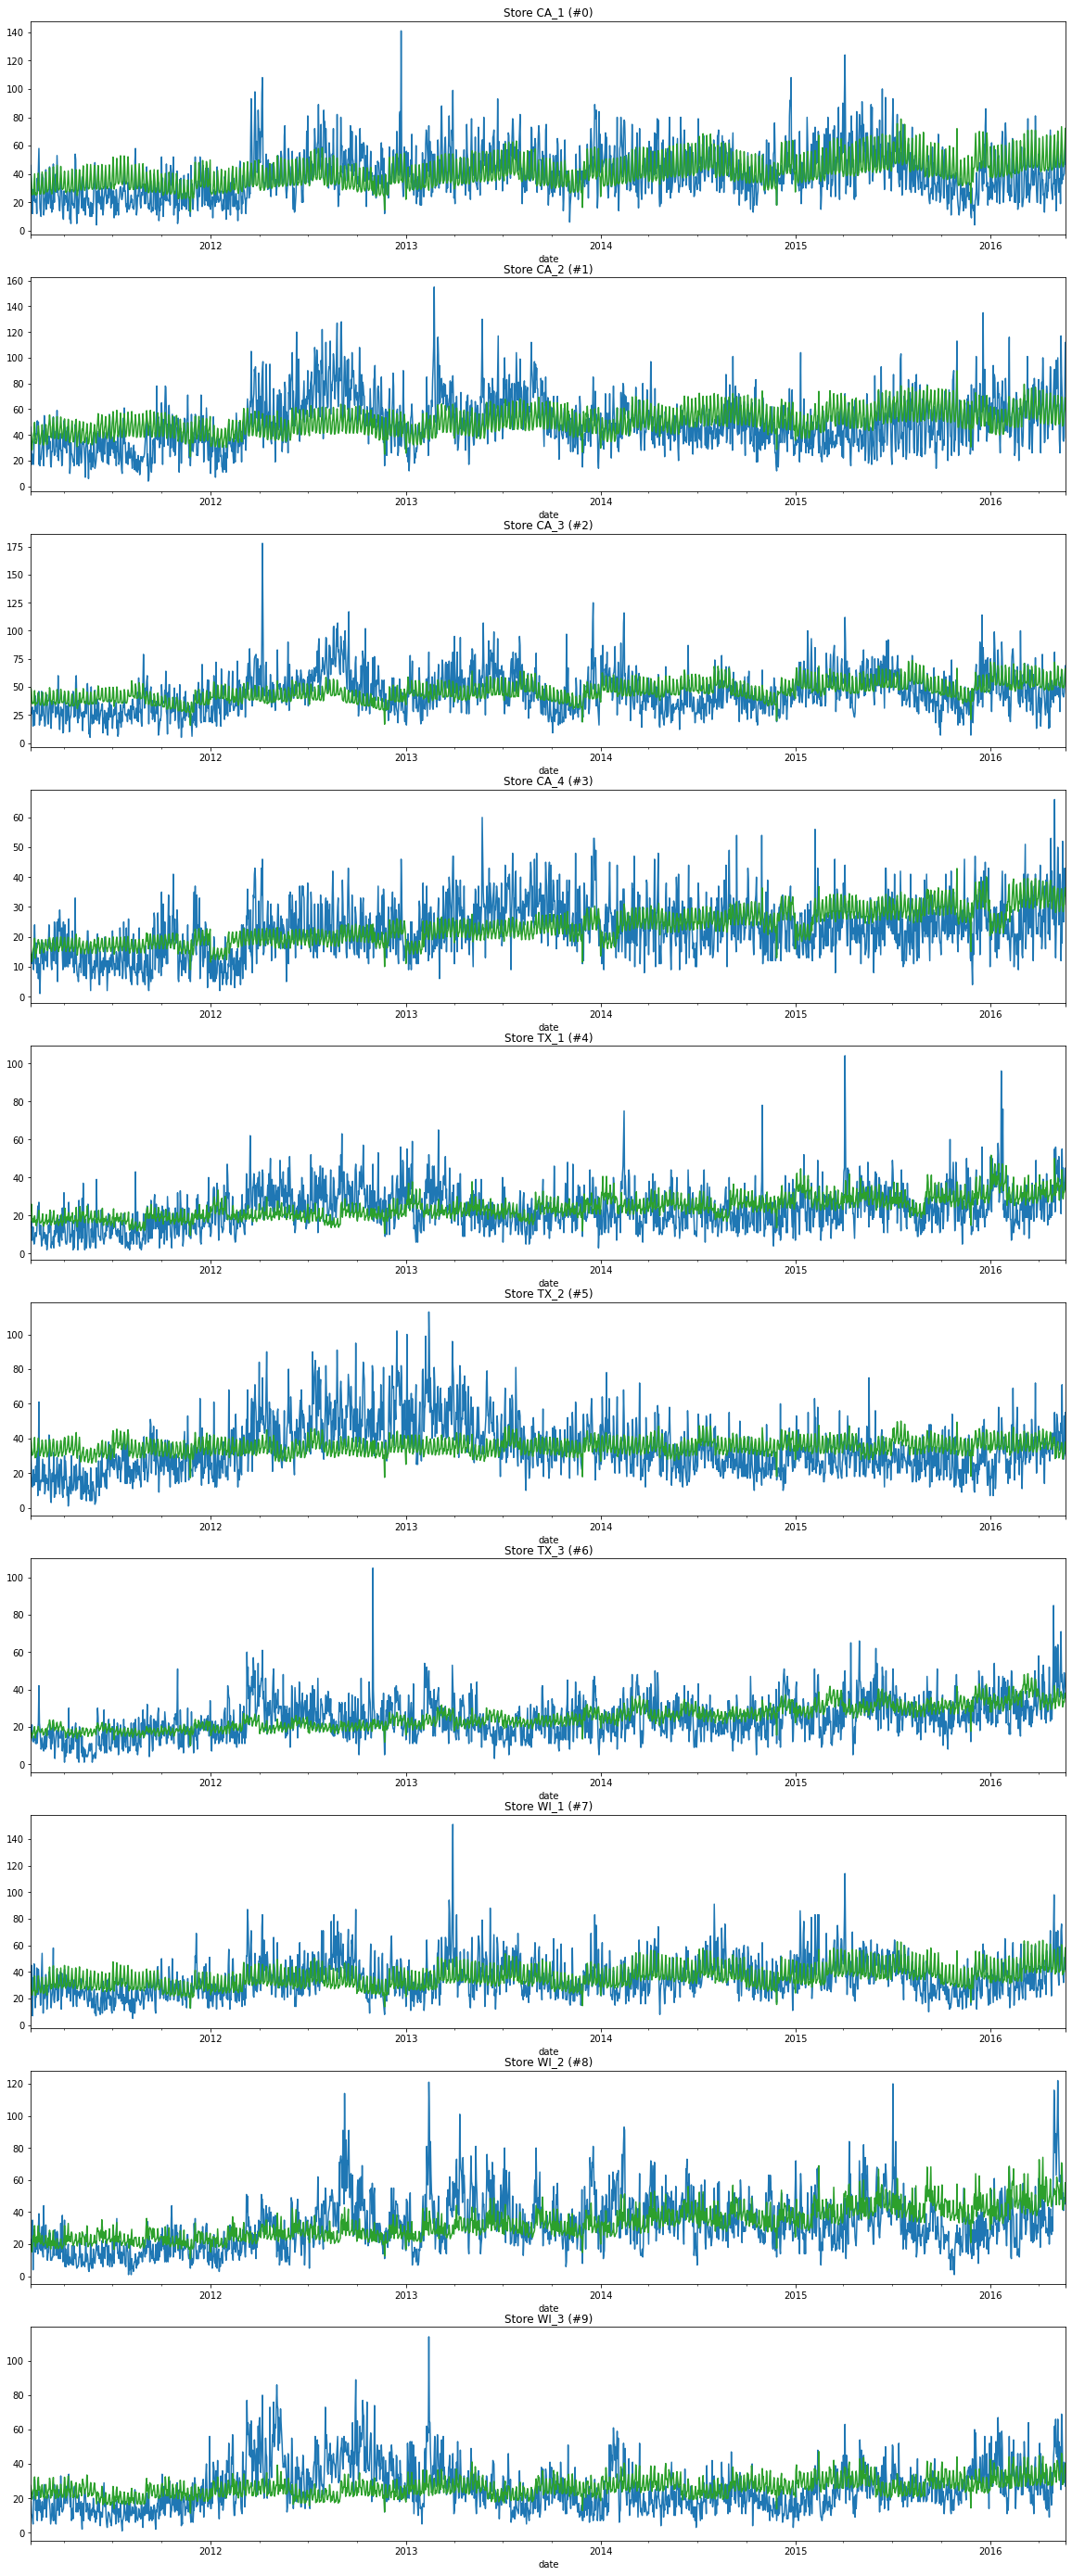

In [32]:
n_stores = len(q['store_id'])
fig, axs = plt.subplots(n_stores, 1, figsize=(20, 5 * n_stores))
for i in range(n_stores):
    ax = axs[i]
    ax.set_title(f"Store {q['store_id'].values[i]} (#{i})")
    _q = q.isel({"store_id": i})
    _q['actual'].to_series().plot(ax=ax, color='C0')
    # _q['median'].to_series().plot(ax=ax, color='C1')
    _q['mean'].to_series().plot(ax=ax, color='C2')
fig;

## Blah

### Define model

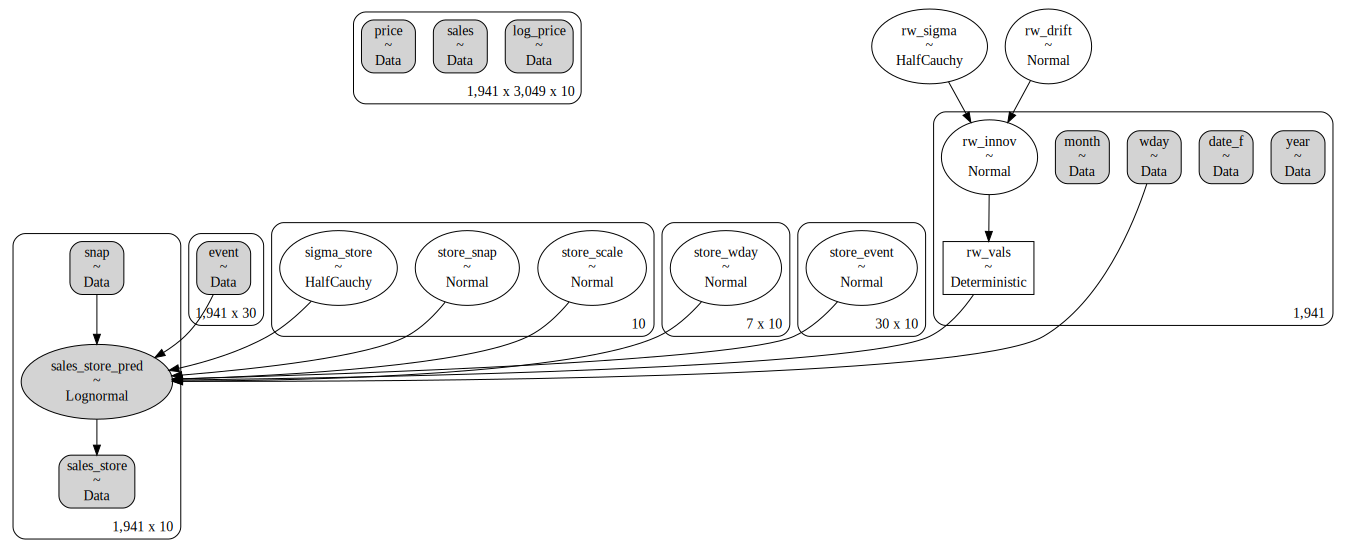

In [385]:
with pm.Model(coords=d.coords) as m:
    for k, v in d.data_vars.items():
        pm.Data(k, v, dims=v.dims)

    # Scale per store
    pm.Normal("store_scale", mu=0, sd=2, dims=["store_id"])
    pm.Normal("store_snap", mu=0, sd=1, dims=["store_id"])
    pm.Normal("store_wday", mu=0, sd=1, dims=["day_of_week", "store_id"])
    
    # Random walk
    # pm.GaussianRandomWalk("rw", mu=, sigma=, init=)
    pm.Normal("rw_drift", mu=0, sd=0.5)
    pm.HalfCauchy("rw_sigma", beta=0.5)
    pm.Normal("rw_innov", mu=m['rw_drift'], sigma=m['rw_sigma'], dims=['date'])
    pm.Deterministic("rw_vals", tt.cumsum(m['rw_innov'], axis=0), dims=['date'])
    
    # Events
    pm.Normal("effect_event", mu=0, sd=1, dims=['event_name'])
    # pm.Deterministic("", , dims=['date'])

    # Sigma
    pm.HalfCauchy("sigma_store", beta=2, dims=['store_id'])
    # pm.Exponential("sigma_store", lam=2, dims=['store_id'])
    
    pm.Lognormal(
        "sales_store_pred",
        mu=(
            m["store_scale"][np.newaxis, :]
            + m["store_wday"][m["wday"] - 1, :]
            + m["store_snap"][np.newaxis, :] * m["snap"]
            + m['rw_vals'][:, np.newaxis]
            + m['event'] @ m['store_event'][:, np.newaxis]
        ),
        sigma=m['sigma_store'],
        observed=m['sales_store'],
        dims=["date", "store_id"],
    )

gv = pm.model_to_graphviz(m)
display(gv)

### Fit

In [370]:
with m:
    trace = pm.sample(
        draws=500,
        tune=500,
        chains=4,
        target_accept=0.8,
        return_inferencedata=True,
        # init="adapt_diag",
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_store, rw_innov, rw_sigma, rw_drift, store_wday, store_snap, store_scale]


Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 874 seconds.


0, dim: date, 1941 =? 1941
1, dim: store_id, 10 =? 10


The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [387]:
tm = trace.posterior.mean(dim=['chain', 'draw'])
tm

<xarray.Dataset>
Dimensions:      (date: 1941, day_of_week: 7, event_name: 30, store_id: 10)
Coordinates:
  * store_id     (store_id) object 'CA_1' 'CA_2' 'CA_3' ... 'WI_1' 'WI_2' 'WI_3'
  * day_of_week  (day_of_week) int64 0 1 2 3 4 5 6
  * date         (date) datetime64[ns] 2011-01-29 2011-01-30 ... 2016-05-22
  * event_name   (event_name) object 'SuperBowl' 'ValentinesDay' ... 'Easter'
Data variables:
    store_scale  (store_id) float64 0.8003 0.3317 0.941 ... 0.4922 0.339 0.4653
    store_snap   (store_id) float64 0.07269 -0.003859 0.07826 ... 0.2513 0.2069
    store_wday   (day_of_week, store_id) float64 0.2162 0.4623 ... 0.1744 0.1057
    rw_drift     float64 0.003252
    rw_innov     (date) float64 6.982 0.2794 -0.05295 ... -0.007956 0.07146
    store_event  (event_name, store_id) float64 -0.06172 -0.06272 ... -0.1575
    rw_sigma     float64 0.187
    rw_vals      (date) float64 6.982 7.262 7.209 7.262 ... 7.745 7.737 7.808
    sigma_store  (store_id) float64 0.06824 0.1559 0.1693 ... 0.3373 0.2899

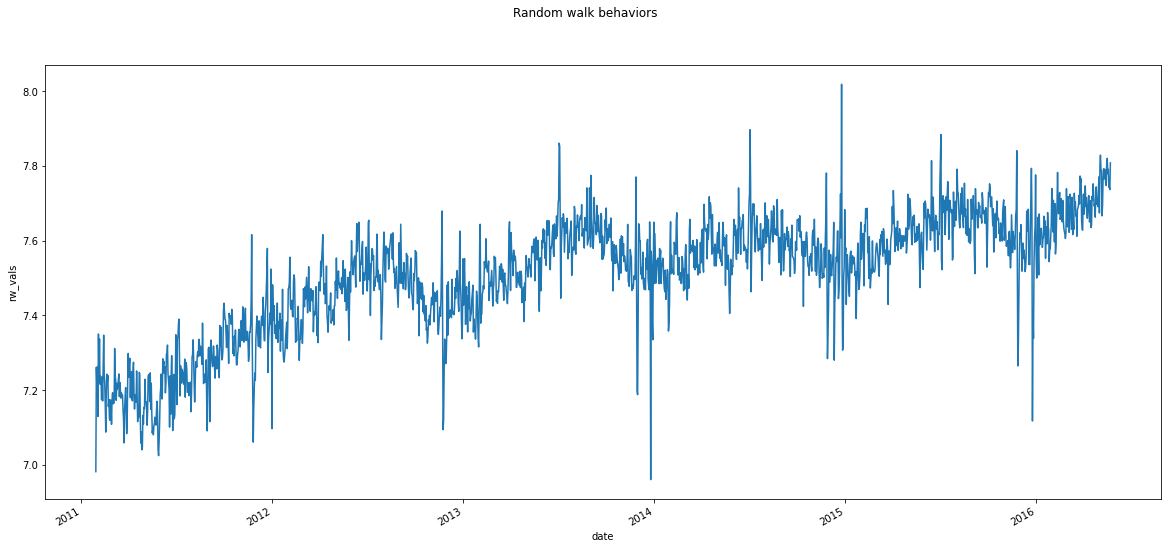

In [388]:
fig, ax = plt.subplots(figsize=(20, 8))
fig.suptitle("Random walk behaviors")
tm['rw_vals'].plot.line(x='date', ax=ax)
fig;

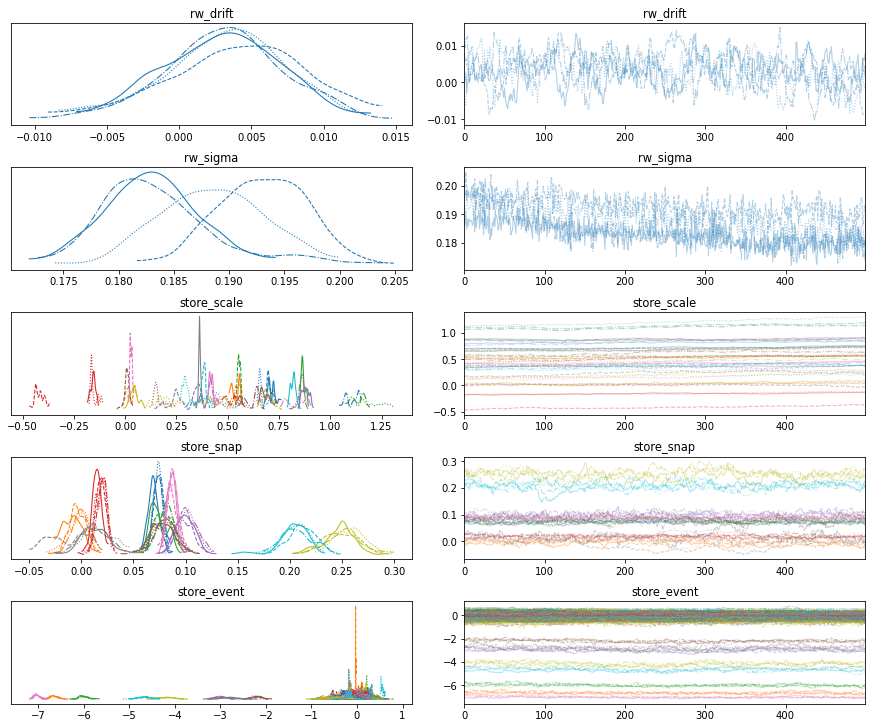

In [390]:
# az.plot_trace(trace);
# az.plot_trace(trace, var_names=['store_scale']);
az.plot_trace(trace, var_names=['rw_drift', 'rw_sigma', 'store_scale', 'store_snap', 'store_event']);

In [391]:
with m:
    ppc_raw = pm.sample_posterior_predictive(trace)
    ifd2 = az.from_pymc3(posterior_predictive=ppc_raw)
ppc = ifd2.posterior_predictive
# dims = ['sample', 'item_id', 'store_id', 'date']
# coords = {k: x.coords[k] for k in dims if k in x.coords}
# ppc = xr.DataArray(ppc_raw['y'], dims=dims, coords=coords).to_dataset(name='y')

INFO (theano.gof.compilelock): Refreshing lock /home/anatoly/.theano/compiledir_Linux-5.4--generic-x86_64-with-glibc2.10-x86_64-3.8.6-64/lock_dir/lock


In [392]:
_raw = ppc['sales_store_pred']
q = xr.Dataset({
    "actual": d["sales_store"],
    "raw": _raw,
    "mean": _raw.mean(dim=['chain', 'draw']),
    "median": _raw.median(dim=['chain', 'draw']),
})

In [393]:
q

<xarray.Dataset>
Dimensions:   (chain: 1, date: 1941, draw: 2000, store_id: 10)
Coordinates:
  * store_id  (store_id) object 'CA_1' 'CA_2' 'CA_3' ... 'WI_1' 'WI_2' 'WI_3'
    state_id  (store_id) object 'CA' 'CA' 'CA' 'CA' 'TX' ... 'TX' 'WI' 'WI' 'WI'
  * date      (date) datetime64[ns] 2011-01-29 2011-01-30 ... 2016-05-22
    historic  (date) bool True True True True True ... True True True True True
    future    (date) bool False False False False ... False False False False
  * chain     (chain) int64 0
  * draw      (draw) int64 0 1 2 3 4 5 6 ... 1993 1994 1995 1996 1997 1998 1999
Data variables:
    actual    (date, store_id) float64 4.337e+03 3.494e+03 ... 4.757e+03
    raw       (chain, draw, date, store_id) float64 3.074e+03 ... 4.614e+03
    mean      (date, store_id) float64 2.981e+03 2.397e+03 ... 5.212e+03
    median    (date, store_id) float64 2.969e+03 2.365e+03 ... 4.968e+03

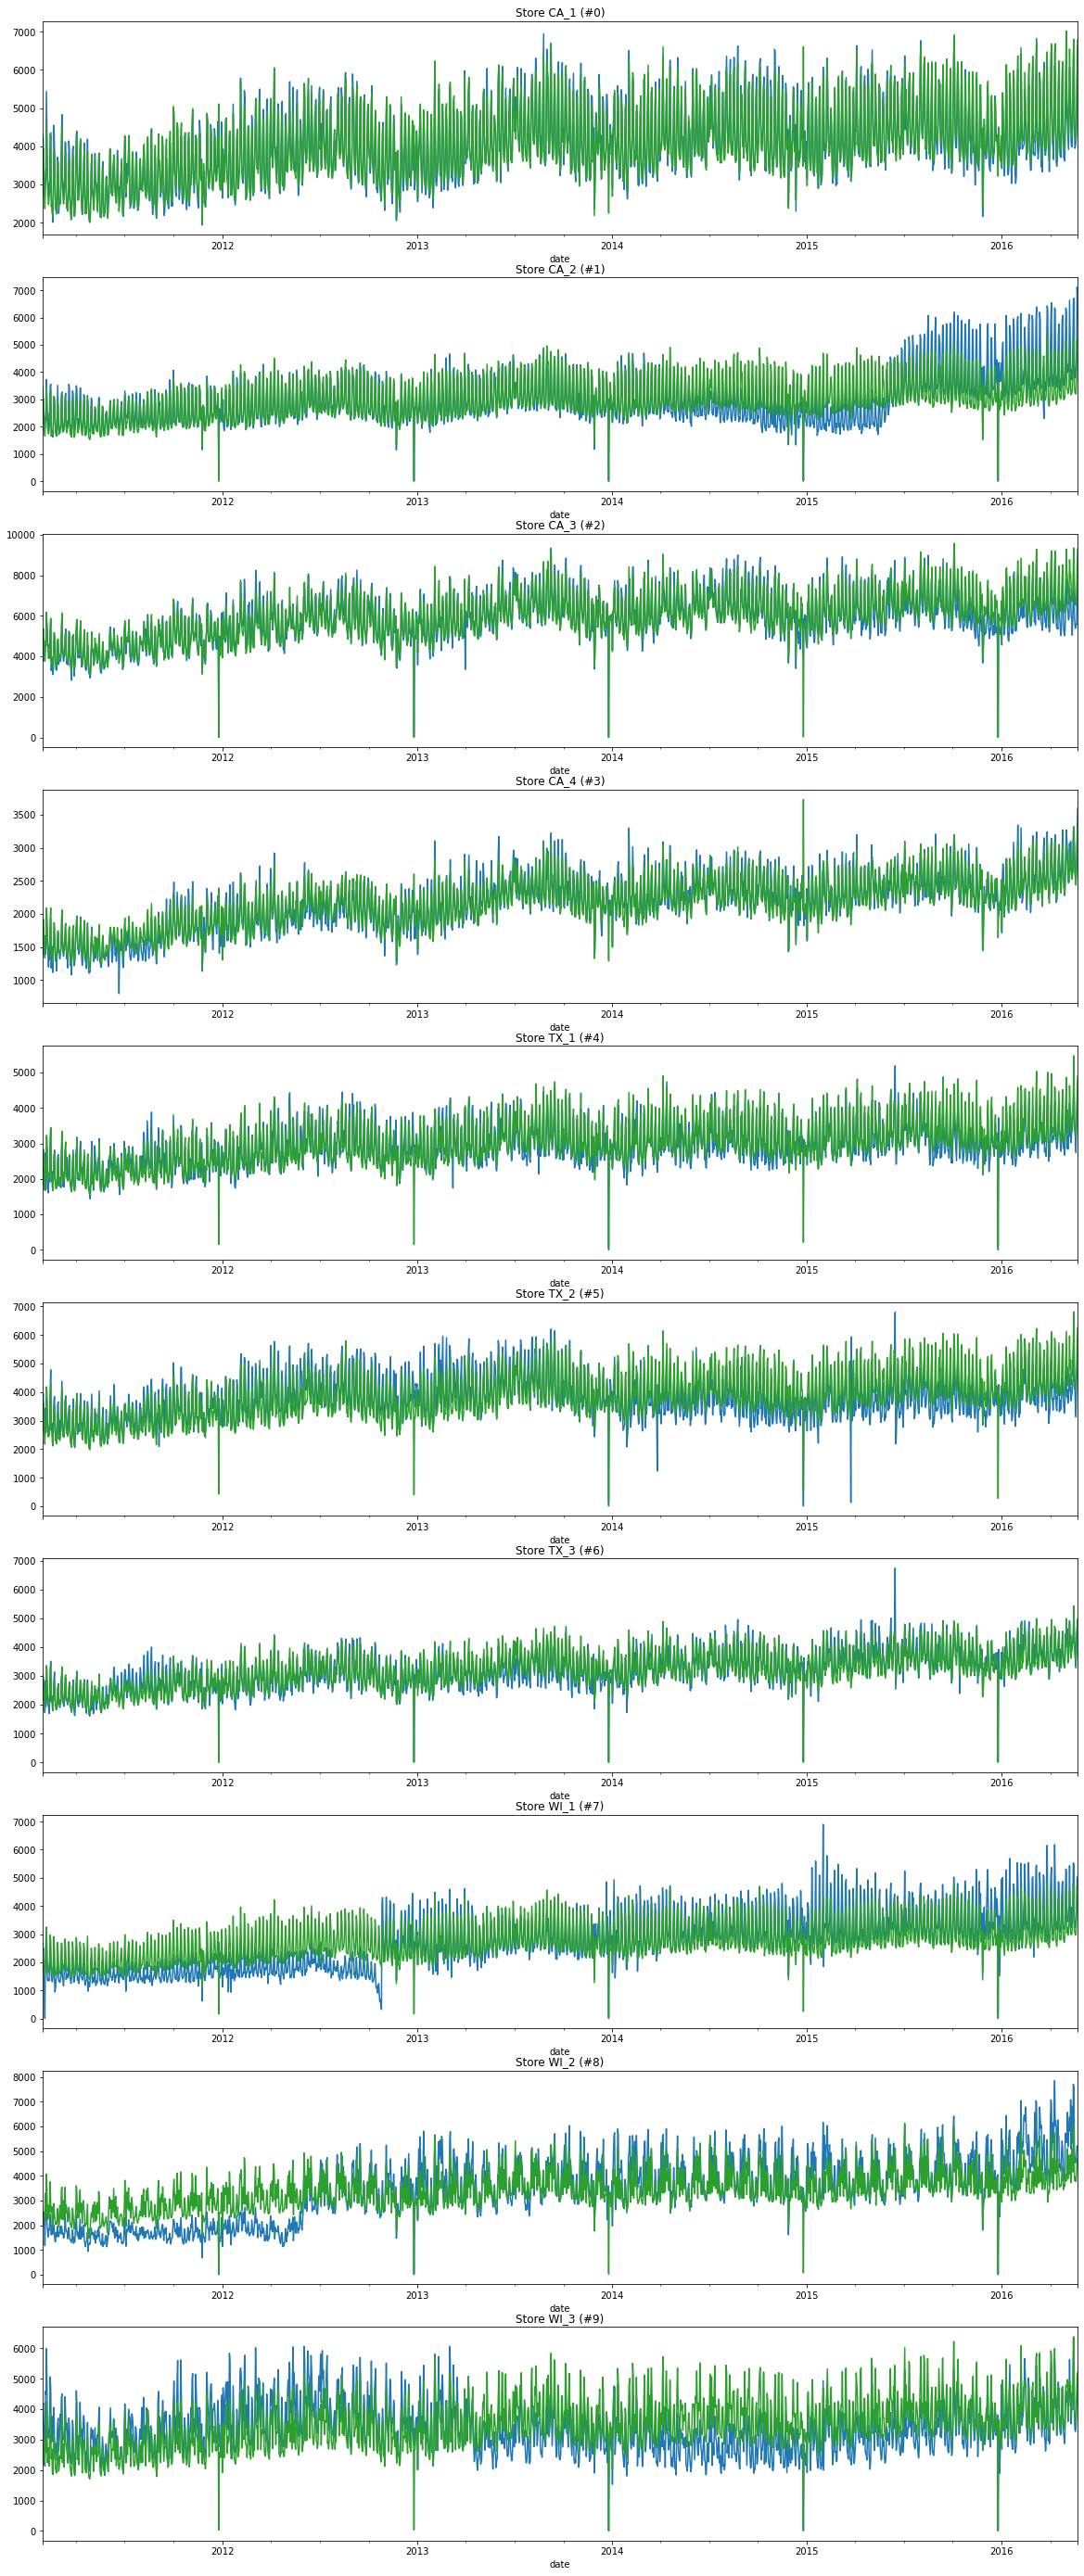

In [394]:
n_stores = len(q['store_id'])
fig, axs = plt.subplots(n_stores, 1, figsize=(20, 5 * n_stores))
for i in range(n_stores):
    ax = axs[i]
    ax.set_title(f"Store {q['store_id'].values[i]} (#{i})")
    _q = q.isel({"store_id": i})
    _q['actual'].to_series().plot(ax=ax, color='C0')
    # _q['median'].to_series().plot(ax=ax, color='C1')
    _q['mean'].to_series().plot(ax=ax, color='C2')
fig;